In [1]:
import numpy as np
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import find_optimal_svd_rank
from polara import (SVDModel,
                    PopularityModel,
                    RandomModel)
from polara.recommender.hybrid.models import SimilarityAggregation
from polara.recommender.coldstart.models import (SVDModelItemColdStart,
                                                 RandomModelItemColdStart,
                                                 PopularityModelItemColdStart,
                                                 SimilarityAggregationItemColdStart)

from data_preprocessing import (get_movielens_data,
                                get_bookcrossing_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)
%matplotlib inline

Use token from .telepythrc.


In [2]:
from polara.recommender import defaults
defaults.memory_hard_limit = 5 # allowed memory usage during recommendations generation

In [3]:
seed = 42

In [4]:
experiment_name = 'baseline'

# Experiment setup

In [5]:
data_labels = ['ML1M', 'ML10M', 'BX']

In [6]:
ranks_grid = [1, 5, 10, 15, 20, 30, 50, 60, 75, 100, 125, 150, 200, 250, 300, 350, 400,
              500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
svd_ranks = {'ML1M': [r for r in ranks_grid if r <= 1000],
             'ML10M': [r for r in ranks_grid if r <= 1000],
             'BX': [r for r in ranks_grid if r <= 2000]}

In [7]:
topk_values = [1, 3, 10, 20, 30]

In [8]:
target_metric = 'mrr'

In [9]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)

In [10]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Movielens1M

In [11]:
lbl = 'ML1M'

In [12]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('D:/datasets/recsys/movielens/ml-1m.zip',
                                                    meta_path='data/meta_info_ml1m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [13]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [14]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Movielens10M

In [15]:
lbl = 'ML10M'

In [16]:
data_dict[lbl], meta_dict[lbl] = get_movielens_data('D:/datasets/recsys/movielens/ml-10m.zip',
                                                    meta_path='data/meta_info_ml10m.csv',
                                                    implicit=True,
                                                    filter_no_meta=True)

In [17]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [18]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## BookCrossing

In [19]:
lbl = 'BX'

In [20]:
data_dict[lbl], meta_dict[lbl] = get_bookcrossing_data('D:/datasets/recsys/bookcrossing/BX-CSV-Dump.zip',
                                                       get_books_meta=True,
                                                       implicit=True,
                                                       filter_no_meta=True)

In [21]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [22]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [23]:
print_data_stats(data_labels, all_data)

ML1M
{'userid': 6038, 'movieid': 3522}
density 2.699052132255699
similarity matrix density 51.672185638677114
ML10M
{'userid': 69797, 'movieid': 10258}
density 0.6991397242349022
similarity matrix density 51.91219966091452
BX
{'userid': 7160, 'isbn': 16273}
density 0.18925598044812894
similarity matrix density 0.4827469267285518


# Standard experiment

In [24]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    models = [SVDModel(data_model),
              SimilarityAggregation(data_model),
              PopularityModel(data_model),
              RandomModel(data_model, seed=seed)]
    apply_config(models, config, data_label)
    return models


def fine_tune_svd(model, ranks, label, record_time=False):
    best_svd_rank, svd_scores = find_optimal_svd_rank(model, ranks, target_metric,
                                                      return_scores=True,
                                                      iterator=lambda x: track(x, label=label))
    model_config = {model.method: {'rank': best_svd_rank}}
    model_scores = {model.method: svd_scores}
    try:
        if record_time:
            max_rank = max(ranks)
            save_training_time(f'{experiment_name}_rank_{max_rank}', model, pd.Index([max_rank], name='rank'), label)
    finally:
        return model_config, model_scores

## tuning

In [25]:
config = {}
scores = {}
data_models = {}

In [26]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    config[label], scores[label] = fine_tune_svd(SVDModel(data_models[label]),
                                                 svd_ranks[label],
                                                 label, True)

 [████████████████████████████████████████████████████████████] 3/3 [06:04<02:45, 121.31s/it]

           ML1M [█████████████████████████████████████████████] 20/20 [00:03<00:00, 0.17s/it]

          ML10M [█████████████████████████████████████████████] 20/20 [01:06<00:02, 3.30s/it]

             BX [█████████████████████████████████████████████] 24/24 [00:15<00:00, 0.62s/it]

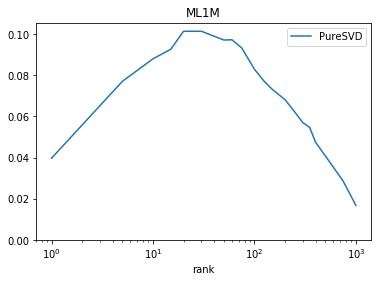

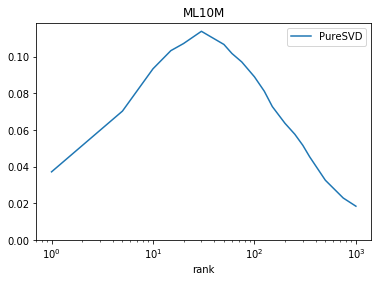

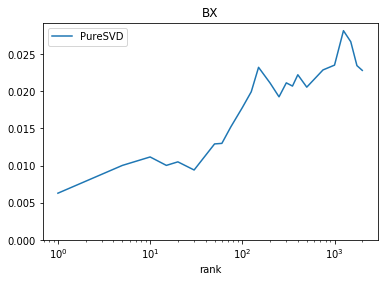

In [27]:
report_results('rank', scores);

In [28]:
config

{'ML1M': {'PureSVD': {'rank': 30}},
 'ML10M': {'PureSVD': {'rank': 30}},
 'BX': {'PureSVD': {'rank': 1250}}}

### saving data

In [29]:
save_results(experiment_name, config=config, tuning=scores)

## cross-validation

In [31]:
result = {}
for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, config)
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=f'{label} folds'))
    save_cv_training_time(experiment_name, models, label)

 [████████████████████████████████████████████████████████████] 3/3 [08:14<05:05, 164.78s/it]

     ML1M folds [█████████████████████████████████████████████] 5/5 [00:10<00:02, 2.08s/it]

    ML10M folds [█████████████████████████████████████████████] 5/5 [02:59<00:37, 35.76s/it]

       BX folds [█████████████████████████████████████████████] 5/5 [05:05<01:01, 61.00s/it]

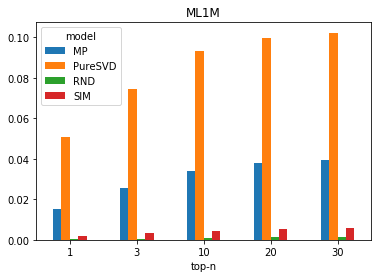

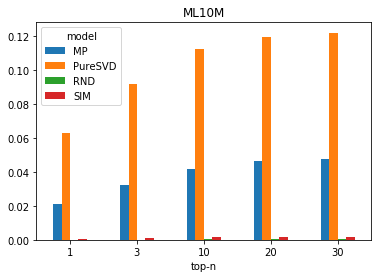

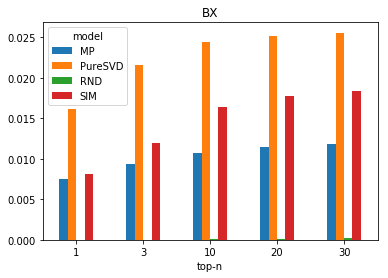

In [32]:
report_results('topn', result, target_metric);

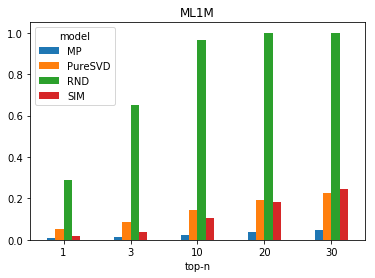

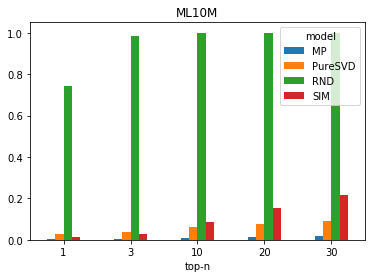

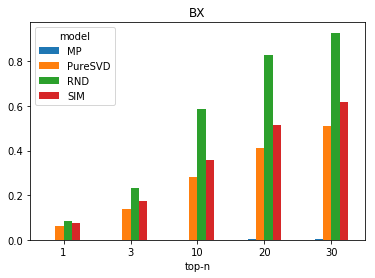

In [33]:
report_results('topn', result, 'coverage');

### saving data

In [34]:
save_results(experiment_name, cv=result)

# Cold start

In [35]:
def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    models = [SVDModelItemColdStart(data_model, item_features=meta_dict[data_label]),
              SimilarityAggregationItemColdStart(data_model),
              PopularityModelItemColdStart(data_model),
              RandomModelItemColdStart(data_model, seed=seed)]
    apply_config(models, config, data_label)
    return models

## tuning

In [36]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [39]:
for label in track(data_labels):
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model = SVDModelItemColdStart(data_models_cold[label],
                                  item_features=meta_dict[label])
    model.use_raw_features = True
    config_cold[label], scores_cold[label] = fine_tune_svd(model,
                                                           svd_ranks[label],
                                                           label)
    del model

 [████████████████████████████████████████████████████████████] 3/3 [06:01<02:49, 120.46s/it]

           ML1M [█████████████████████████████████████████████] 20/20 [00:04<00:00, 0.22s/it]

          ML10M [█████████████████████████████████████████████] 20/20 [00:57<00:03, 2.86s/it]

             BX [█████████████████████████████████████████████] 24/24 [00:27<00:00, 1.14s/it]

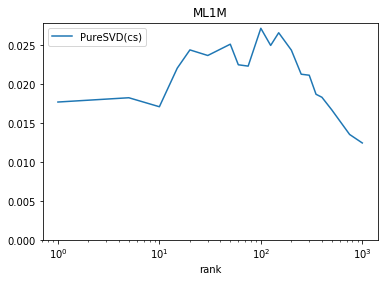

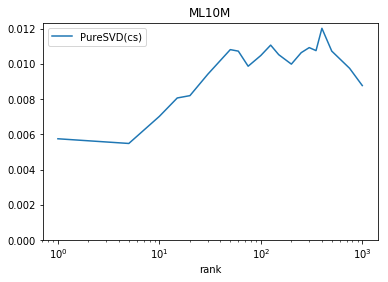

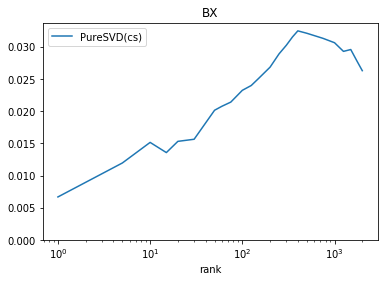

In [40]:
report_results('rank', scores_cold);

In [41]:
config_cold

{'ML1M': {'PureSVD(cs)': {'rank': 100}},
 'ML10M': {'PureSVD(cs)': {'rank': 400}},
 'BX': {'PureSVD(cs)': {'rank': 400}}}

### saving data

In [42]:
save_results(experiment_name+'_coldstart', config=config_cold, tuning=scores_cold)

## cross validation

In [47]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold, config_cold)
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=f'{label} folds'))

 [████████████████████████████████████████████████████████████] 3/3 [05:49<01:02, 116.36s/it]

     ML1M folds [█████████████████████████████████████████████] 5/5 [00:12<00:02, 2.46s/it]

    ML10M folds [█████████████████████████████████████████████] 5/5 [04:35<00:55, 54.92s/it]

       BX folds [█████████████████████████████████████████████] 5/5 [01:02<00:12, 12.43s/it]

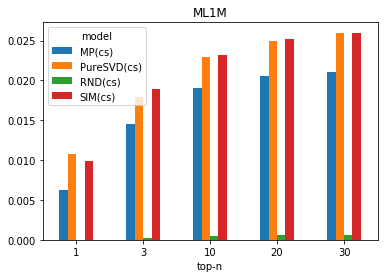

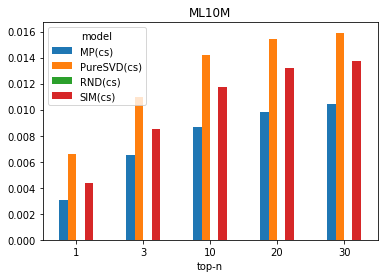

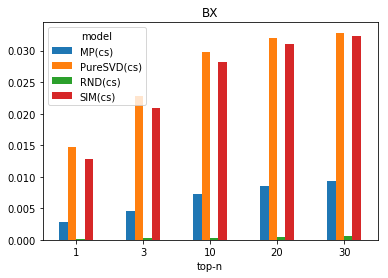

In [48]:
report_results('topn', result_cold, target_metric);

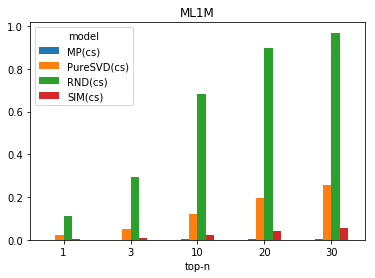

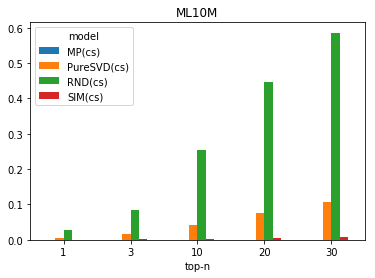

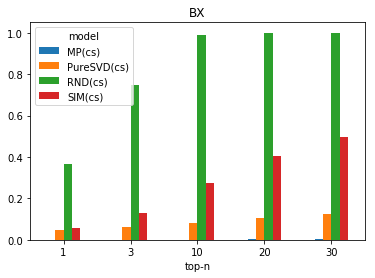

In [49]:
report_results('topn', result_cold, 'coverage');

### saving data

In [50]:
save_results(experiment_name+'_coldstart', cv=result_cold)